In [1]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
import warnings
warnings.filterwarnings("ignore")

c:\Users\Administrator\Desktop\RAG Using Agentic AI\rag_env\Lib\site-packages\IPython\core\interactiveshell.py:3667: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct")

In [4]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [5]:
docs = [WebBaseLoader(url).load() for url in urls]

In [6]:
docs_list = [item for sublist in docs for item in sublist]

In [7]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)

In [8]:
doc_splits=text_splitter.split_documents(docs_list)

In [9]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [10]:
retriever=vectorstore.as_retriever()

In [11]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    
)

In [12]:
tools=[retriever_tool]

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
class grade(BaseModel):
    binary_score:str = Field(description="The score of the answer, either 'yes' or 'no'.")

In [15]:
def AI_Assistance(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']

    
    if len(messages)>1:
        response=llm.invoke(messages[-1].content)
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [16]:
retrieve = ToolNode([retriever_tool])

In [17]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]

    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [18]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [19]:
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state['messages']
    question = messages[0].content
    message = [
        HumanMessage(
            content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: 
                    \n -------------- \n
                    {question} 
                    \n -------------- \n
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [20]:
workflow = StateGraph(AgentState)
workflow.add_node("ai_assistant", AI_Assistance)
workflow.add_node("retriever", retrieve)
workflow.add_node("rewriter", rewrite)
workflow.add_node("generator", generate)

In [21]:
workflow.add_edge(START, "ai_assistant")
workflow.add_conditional_edges("ai_assistant",tools_condition, {"tools":"retriever",END:END})

In [22]:
workflow.add_conditional_edges("retriever", 
                               grade_documents, 
                               {"rewriter":"rewriter","generator":"generator"})

In [23]:
workflow.add_edge("generator", END)
workflow.add_edge("rewriter", "ai_assistant")


In [24]:
app = workflow.compile()

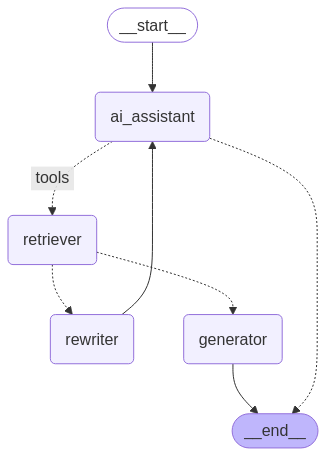

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [26]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='69c999cc-172f-4b81-b7a8-341e1351ccbe'),
  AIMessage(content="An autonomous agent is a type of artificial intelligence (AI) system that can perform tasks without human intervention. Autonomous agents are designed to operate independently, making decisions and taking actions based on their own reasoning, perception, and learning.\n\nAutonomous agents can be classified into different types, including:\n\n1. **Simple reflex agents**: These agents react to the current state of the environment without considering future consequences.\n2. **Model-based reflex agents**: These agents maintain an internal model of the environment and use it to make decisions.\n3. **Goal-based agents**: These agents have specific goals and can plan to achieve them.\n4. **Utility-based agents**: These agents make decisions based on a utility function that estimates the desirability of different actions

In [27]:
app.invoke({"messages":["What is a Prompt Engineering?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='What is a Prompt Engineering?', additional_kwargs={}, response_metadata={}, id='921b4f40-fb56-47a6-b561-8866eefc4965'),
  AIMessage(content="Prompt engineering is a technique used to improve the performance of language models, such as large language models (LLMs), by carefully designing and optimizing the input prompts or queries provided to the model. The goal of prompt engineering is to elicit specific, accurate, and relevant responses from the model.\n\nTraditional language models are trained on vast amounts of text data and can generate text based on a given prompt. However, the quality and relevance of the generated text can vary greatly depending on the prompt. A well-designed prompt can significantly improve the model's performance, while a poorly designed prompt can lead to subpar or even incorrect responses.\n\nPrompt engineering involves analyzing the model's behavior, understanding its strengths and weaknesses, and crafting prompts that ar

In [28]:
app.invoke({"messages":["What is a Prompt Engineering?"]})

---CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is a Prompt Engineering?', additional_kwargs={}, response_metadata={}, id='4e1e9056-91a9-4c72-ab74-807658f54a43'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1p1m', 'function': {'arguments': '{"query": "Prompt Engineering"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 364, 'total_tokens': 381, 'completion_time': 0.033508508, 'prompt_time': 0.011225992, 'queue_time': 0.050758763, 'total_time': 0.0447345}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_5b1ac042bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d66d1e95-a2f8-4c47-a367-7cd006947ca5-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Prompt Engineering'}, 'id': 'call_1p1m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 364, 'output_tokens': 17, 'total_tokens': 381}),
  ToolMessage(content='Prompt

In [29]:
app.invoke({"messages":["Who was the First Prime Minister of india?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='Who was the First Prime Minister of india?', additional_kwargs={}, response_metadata={}, id='1881f6f9-bede-41e7-ba70-3946b13e1385'),
  AIMessage(content='Jawaharlal Nehru was the first Prime Minister of India. He served from August 15, 1947, to May 27, 1964.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 367, 'total_tokens': 402, 'completion_time': 0.071901638, 'prompt_time': 0.014293639, 'queue_time': 0.214149681, 'total_time': 0.086195277}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_5b1ac042bf', 'finish_reason': 'stop', 'logprobs': None}, id='run-2cb34e2f-1465-4305-90cb-b39b662deb3c-0', usage_metadata={'input_tokens': 367, 'output_tokens': 35, 'total_tokens': 402})]}

In [30]:
app.invoke({"messages":["List the name of all prime minister of India?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='List the name of all prime minister of India?', additional_kwargs={}, response_metadata={}, id='00516f9a-e05a-43e9-9abd-16332de9cacb'),
  AIMessage(content="Here's a list of all the Prime Ministers of India:\n\n1. Jawaharlal Nehru (1947-1964)\n2. Gulzarilal Nanda (1964)\n3. Lal Bahadur Shastri (1964-1966)\n4. Gulzarilal Nanda (1966)\n5. Indira Gandhi (1966-1977)\n6. Morarji Desai (1977-1979)\n7. Charan Singh (1979-1980)\n8. Indira Gandhi (1980-1984)\n9. Rajiv Gandhi (1984-1989)\n10. V.P. Singh (1989-1990)\n11. Chandra Shekhar (1990-1991)\n12. P.V. Narasimha Rao (1991-1996)\n13. Atal Bihari Vajpayee (1996)\n14. H.D. Deve Gowda (1996-1997)\n15. I.K. Gujral (1997-1998)\n16. Atal Bihari Vajpayee (1998-2004)\n17. Manmohan Singh (2004-2014)\n18. Narendra Modi (2014-present)\n\nThere have been a total of 18 Prime Ministers of India so far.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 269, 'prompt_tokens': 368, 'total_token